# Clustering with Gaussian Mixture Models

### Preliminaries

- Goal 
  - Introduction to the Expectation-Maximization (EM) Algorithm with application to Gaussian Mixture Models (GMM)
- Materials        
  - Mandatory
    - These lecture notes
  - Optional
    - Bishop pp. 430-439 for Gaussian Mixture Models

###  Limitations of Simple IID Gaussian Models

Sofar, model inference was solved analytically, but we used strong assumptions:

- IID sampling, $p(D) = \prod_n p(x_n)$

- Simple Gaussian (or multinomial) PDFs, $p(x_n) = \mathcal{N}(x_n|\mu,\Sigma)$

- Some limitations of Simple Gaussian Models with IID Sampling:
  - What if the PDF is **multi-modal** (or is just not Gaussian in any other way)?
  - Covariance matrix $\Sigma$ has $D(D+1)/2$ parameters.
    - This quickly becomes **a very large number** for increasing dimension $D$.
  - Temporal signals are often **not IID**.

###  Towards More Flexible Models

-  What if the PDF is multi-modal (or is just not Gaussian in any other way)?
  -   **Discrete latent** variable models (a.k.a. **mixture** models). We'll cover this case in this lesson.
  

  
-  Covariance matrix $\Sigma$ has $D(D+1)/2$ parameters. This quickly becomes very large for increasing dimension $D$.
  -  **Continuous latent** variable models (a.k.a. **dimensionality reduction** models). Covered in [lesson 11](http://nbviewer.ipython.org/github/bertdv/AIP-5SSB0/blob/master/lessons/notebooks/11_Continuous-Latent-Variable-Models-PCA-and-FA.ipynb).

-  Temporal signals are often not IID.
  -  Introduce **Markov dependencies** and **latent state** variable models. This will be covered in [lesson 13](http://nbviewer.jupyter.org/github/bertdv/AIP-5SSB0/blob/master/lessons/notebooks/13_Dynamic-Latent-Variable-Models.ipynb).
    

### Illustrative Example

- You're now asked to build a density model for a data set ([Old Faithful](https://en.wikipedia.org/wiki/Old_Faithful), Bishop pg. 681) that clearly is not distributed as a single Gaussian:

<img src="./figures/fig-Bishop-A5-Old-Faithfull.png" width="350">

###  Unobserved Classes

Consider again a set of observed data $D=\{x_1,\dotsc,x_N\}$

- This time we suspect that there are unobserved class labels that would help explain (or predict) the data, e.g.,
  - the observed data are the color of living things; the unobserved classes are animals and plants.
  - observed are wheel sizes; unobserved categories are trucks and personal cars.
  - observed is an audio signal; unobserved classes include speech, music, traffic noise, etc.
 

   
- Classification problems with unobserved classes are called **Clustering** problems. The learning algorithm needs to **discover the classes from the observed data**.

###  The Gaussian Mixture Model (GMM)
 
- If the categories were observed as well, these data could be nicely modeled by the previously discussed [generative classification framework](http://nbviewer.jupyter.org/github/bertdv/AIP-5SSB0/blob/master/lessons/07_generative_classification/Generative-Classification.ipynb).

- Let us use **equivalent model assumptions to linear generative classification**: 
$$\begin{align*} p(x_n,\mathcal{C}_k) &=  \overbrace{p(\mathcal{C}_k)}^{\text{class prior}} \, \overbrace{p(x_n|\mathcal{C}_k)}^{\text{likelihood}}  
= \pi_k \,\mathcal{N}\left(x_n|\mu_k,\Sigma_k \right) \end{align*}$$
where, as previously, we use notational shorthand $\mathcal{C}_k \triangleq (z_{nk}=1)$ and a _hidden_ $1$-of-$K$ selector variable $z_{nk}$ with each observation $x_n$ as 
$$
z_{nk} = \begin{cases} 1 & \text{if  } \, z_n \in \mathcal{C}_k\\
0 & \text{otherwise} \end{cases}
$$

- Since the class labels are not observed, the probability for observations in a GMM is obtained through _marginalization_ over the classes (this is different in classification problems, where the classes are observed):
$$\begin{align*}
p(x_n) = \boxed{\sum_k \pi_k \mathcal{N}\left(x_n|\mu_k,\Sigma_k \right)}
\end{align*}$$
  - The class priors $p(\mathcal{C}_k) =\pi_k$ are often called _mixture coefficients_. 

###  Gaussian Mixture Models

- GMMs are very popular models. They have decent computational properties and are **universal approximators of densities** (as long as there are enough Gaussians of course)

<img src="./figures/fig-ZoubinG-GMM-universal-approximation.png" width="500">



###  Inference: Log-Likelihood for GMM

- The log-likelihood for observed data $D=\{x_1,\dotsc,x_N\}$,
$$\begin{align*}
\log p(D|\theta) &\stackrel{\text{IID}}{=} \sum_n \log p(x_n|\theta)
  = \sum_n \log \left( \sum_{k=1}^K p(\mathcal{C}_k) \, p(x_n|\mathcal{C}_k)  \right) \\
  &= \sum_n \log \left( \sum_k \pi_k\mathcal{N}(x_n|\mu_k,\Sigma_k) \right)
\end{align*}$$
... and now the log-of-sum cannot be further simplified.

- Compare this to the log-likelihood for $D=\{(x_1,y_1),\dotsc,(x_N,y_N)\}$ in [(generative) classification](http://nbviewer.ipython.org/github/bertdv/AIP-5SSB0/blob/master/lessons/notebooks/07_Generative-Classification.ipynb): 
$$\begin{align*}
\log p(D|\theta) &= \sum_n \log \prod_k p(x_n,\mathcal{C}_{k}|\theta)^{y_{nk}} 
 =  \sum_{n,k} y_{nk} \log p(x_n,\mathcal{C}_{k}|\theta) \\
   &=  \sum_k m_k \log \pi_k + \sum_{n,k} y_{nk} \log \mathcal{N}(x_n|\mu_k,\Sigma)
\end{align*}$$
which led to easy Gaussian and multinomial parameter estimation.

- Fortunately GMMs can be trained by maximum likelihood using an efficient algorithm: Expectation-Maximization.

###  Introducing a Soft Class Indicator

Let's introduce a $1$-of-$K$ selector variable $z_{nk}$ to represent the _unobserved_ classes $\mathcal{C}_k$ by 
$$
z_{nk} = \begin{cases} 1 & \text{if $z_n$ in class $\mathcal{C}_k$}\\
        0 & \text{otherwise} \end{cases}
$$

- We don't _observe_ the class labels $z_{nk}$, but we can compute the posterior probability for the class labels, given the observation $x_n$:
$$\begin{align*}
p(\mathcal{C}_k | x_n ) &= \frac{p(x_n|\mathcal{C}_k)p(\mathcal{C}_k)}{\sum_{k^\prime} p(x_n|\mathcal{C}_{k^\prime})p(\mathcal{C}_{k^\prime})} 
  = \frac{\pi_k \mathcal{N}(x_n | \mu_k,\Sigma_k)}{\sum_{k^\prime} \pi_{k^\prime} \mathcal{N}(x_n | \mu_{k^\prime},\Sigma_{k^\prime})}
\end{align*}$$

- The $\gamma_{nk} \triangleq p(\mathcal{C}_k | x_n ) = p(z_{nk}=1 | x_n )$ are also called **responsibilities**. Note that $0 \leq \gamma_{nk} \leq 1$ by definition and that they can be evaluated (i.e., we can compute it).

- The responsibilities $\gamma_{nk}$ are soft class indicators and they play the same role in clustering as class selection variables ($y_{nk}$) do in classification problems. 

###  ML estimation for Clustering: The Expectation-Maximization (EM) Algorithm Idea 

- <span class="emphasis"><b>IDEA</b>: Let's apply the (generative) classification formulas and substitute the reponsibilities $\gamma_{nk}$ wherever the formulas use the binary class indicators $y_{nk}$</span>.

-  Try parameter updates (same as for [generative Gaussian classification](http://nbviewer.ipython.org/github/bertdv/AIP-5SSB0/blob/master/lessons/notebooks/07_Generative-Classification.ipynb)):
$$\begin{align*}
\hat \pi_k &= \frac{m_k}{N}\,,\quad \text{where }m_k = \sum_n \gamma_{nk} \\
\hat \mu_k &= \frac{1}{m_k} \sum_n \gamma_{nk} x_n \\
\hat \Sigma_k  &= \frac{1}{m_k} \sum_{n} \gamma_{nk} (x_n-\hat \mu_k)(x_n-\hat \mu_k)^T
\end{align*}$$

-  But wait ..., the responsibilities $\gamma_{nk}=\frac{\pi_k \mathcal{N}(x_n|\mu_k,\Sigma_k)}{\sum_j \pi_j \mathcal{N}(x_n|\mu_j,\Sigma_j)}$ are a function of the model parameters $\{\pi,\mu,\Sigma\}$ and the parameter updates depend on the responsibilities ...

-  **Solution**: Iterate updating between $\gamma_{nk}$ and the parameters $\{\pi,\mu,\Sigma\}$. This procedure is called the **Expectation-Maximization (EM)** algorithm.

#### CODE EXAMPLE

We'll perform clustering on the data set from the illustrative example by fitting a GMM consisting of two Gaussians using the EM algorithm. 

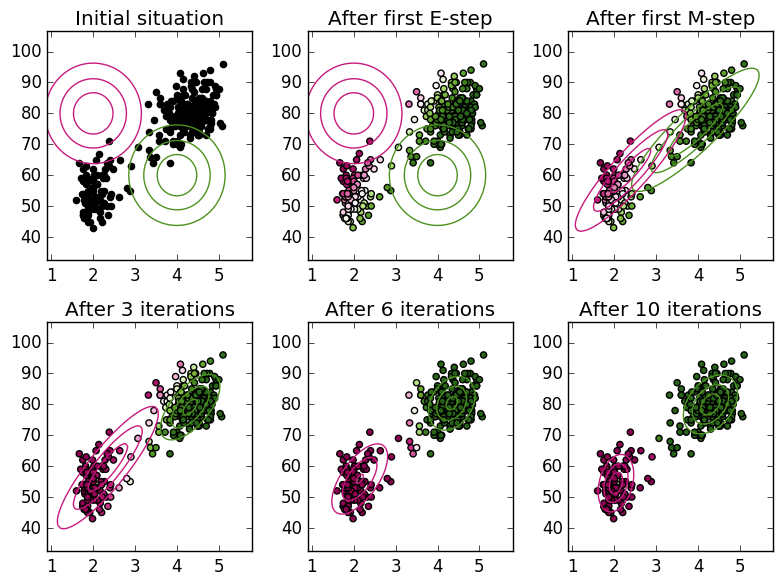

In [1]:
using DataFrames, CSV
include("scripts/gmm_plot.jl") # Holds plotting function 
old_faithful = CSV.read("datasets/old_faithful.csv")
X = convert(Matrix{Float64}, [old_faithful[1] old_faithful[2]]')
N = size(X, 2)

# Initialize the GMM. We assume 2 clusters.
clusters = [MvNormal([4.;60.], diagm([.5;10^2])); 
            MvNormal([2.;80.], diagm([.5;10^2]))]
π_hat = [0.5; 0.5]                    # Mixing weights
γ = fill!(Matrix{Float64}(2,N), NaN)  # Responsibilities (row per cluster)

# Define functions for updating the parameters and responsibilities
function updateResponsibilities!(X, clusters, π_hat, γ)
    # Expectation step: update γ
    norm = [pdf(clusters[1], X) pdf(clusters[2], X)] * π_hat
    γ[1,:] = (π_hat[1] * pdf(clusters[1],X) ./ norm)'
    γ[2,:] = 1 - γ[1,:]
end
function updateParameters!(X, clusters, π_hat, γ)
    # Maximization step: update π_hat and clusters using ML estimation
    m = sum(γ, 2)
    π_hat = m / N
    μ_hat = (X * γ') ./ m'
    for k=1:2
        Z = (X .- μ_hat[:,k])
        Σ_k = Hermitian(((Z .* (γ[k,:])') * Z') / m[k])
        clusters[k] = MvNormal(μ_hat[:,k], convert(Matrix, Σ_k))
    end
end

# Execute the algorithm: iteratively update parameters and responsibilities
subplot(2,3,1); plotGMM(X, clusters, γ); title("Initial situation")
updateResponsibilities!(X, clusters, π_hat, γ)
subplot(2,3,2); plotGMM(X, clusters, γ); title("After first E-step")
updateParameters!(X, clusters, π_hat, γ)
subplot(2,3,3); plotGMM(X, clusters, γ); title("After first M-step")
iter_counter = 1
for i=1:3
    for j=1:i+1
        updateResponsibilities!(X, clusters, π_hat, γ)
        updateParameters!(X, clusters, π_hat, γ)
        iter_counter += 1
    end
    subplot(2,3,3+i); plotGMM(X, clusters, γ); 
    title("After $(iter_counter) iterations")
end
PyPlot.tight_layout()

Note that you can step through the interactive demo yourself by running [this script](https://github.com/bertdv/AIP-5SSB0/blob/master/lessons/notebooks/scripts/interactive_em_demo.jl) in julia. You can run a script in julia by    
`julia> include("path/to/script-name.jl")`

### Clustering vs. (Generative) Classification

<table>
<tr> <td></td><td style="text-align:center"> <b>Classification</b></td> <td style="text-align:center"><b>Clustering</b></td> </tr> 

<tr> <td>1</td><td>Class label $y_n$ is observed</td> <td>Class label $z_n$ is latent</td> </tr>

<tr> <td>2</td><td>log-likelihood <b>conditions</b> on observed class<br />$$\propto \sum_{nk} y_{nk} \log \mathcal{N}(x_n|\mu_k,\Sigma_k)$$</td> <td> log-likelihood <b>marginalizes</b> over latent classes<br />$$\propto \sum_{n}\log \sum_k \pi_k \mathcal{N}(x_n|\mu_k,\Sigma_k)$$</td> </tr>

<tr> <td>3</td><td>'Hard' class selector<br />$$
y_{nk} = \begin{cases} 1 & \text{if $y_n$ in class $\mathcal{C}_k$}\\
        0 & \text{otherwise} \end{cases}
$$</td> <td>'Soft' class responsibility<br />$$\gamma_{nk} = p(\mathcal{C}_k|x_n)$$</td> </tr>

<tr> <td>4</td>
<td>Estimation:<BR /> 
$$\begin{align*}
\hat{\pi}_k &= \frac{1}{N}\sum_n y_{nk} \\
\hat{\mu}_k &= \frac{\sum_n y_{nk} x_n}{\sum_n y_{nk}} \\
\hat{\Sigma}_k &= \frac{\sum_n y_{nk} (x_n-\hat\mu_k)(x_n-\hat\mu_k)^T}{\sum_n y_{nk}}
\end{align*}$$
</td> 
<td>Estimation (1 update of M-step!)<BR />
$$\begin{align*}
\hat{\pi}_k &= \frac{1}{N}\sum_n \gamma_{nk} \\
\hat{\mu}_k &= \frac{\sum_n \gamma_{nk} x_n}{\sum_n \gamma_{nk}} \\
\hat{\Sigma}_k &= \frac{\sum_n \gamma_{nk} (x_n-\hat\mu_k)(x_n-\hat\mu_k)^T}{\sum_n \gamma_{nk}}
\end{align*}$$
</td>
</tr>

</table>

---
The cell below loads the style file

In [2]:
open("../../styles/aipstyle.html") do f
    display("text/html", readstring(f))
end

<!--
This HTML file contains custom styles and some javascript.
Include it a Jupyter notebook for improved rendering.
-->

<!-- Fonts -->
 
 
 
 
 

<!-- Custom style -->


<!-- MathJax styling -->